### Environment Setup

##### Imports

In [1]:
from pathlib import Path

import numpy as np
from PIL import Image
import random
import time
from scipy.spatial import distance

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure, imshow, axis

from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from transformers import Trainer
import torch

import DatasetFunctions

### Model Fine-Tuning

##### Custom Dataset Class

[WindowsPath('VisionData/Trial_0'), WindowsPath('VisionData/Trial_1'), WindowsPath('VisionData/Trial_2'), WindowsPath('VisionData/Trial_3'), WindowsPath('VisionData/Trial_4'), WindowsPath('VisionData/Trial_5')]
Total Samples: 1614


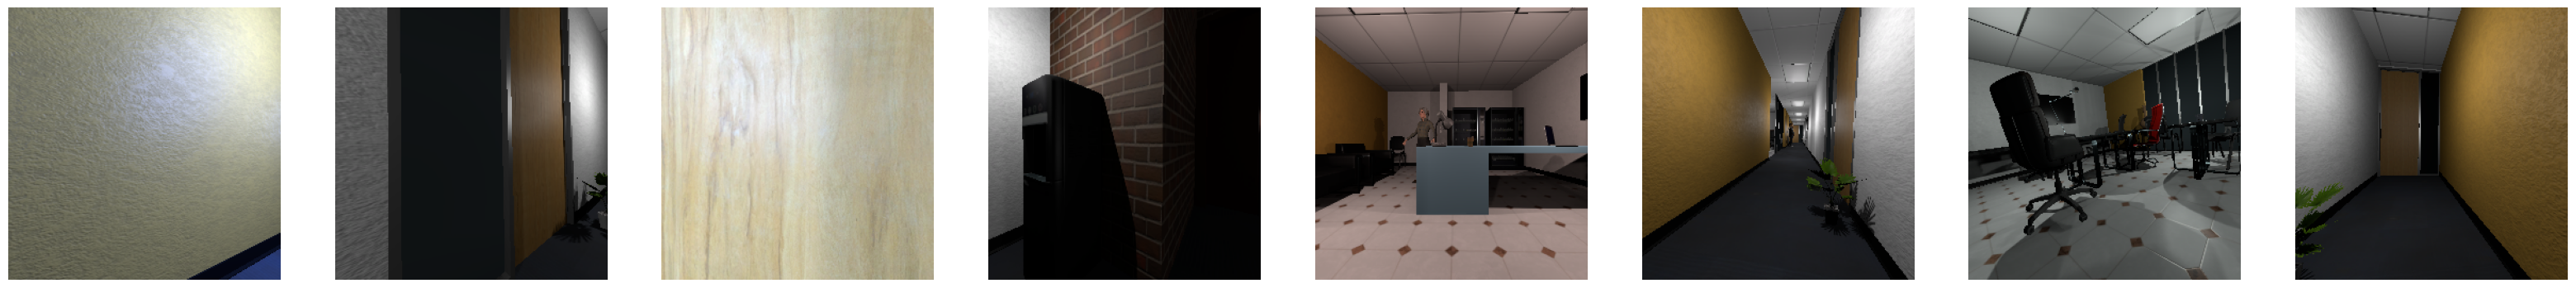

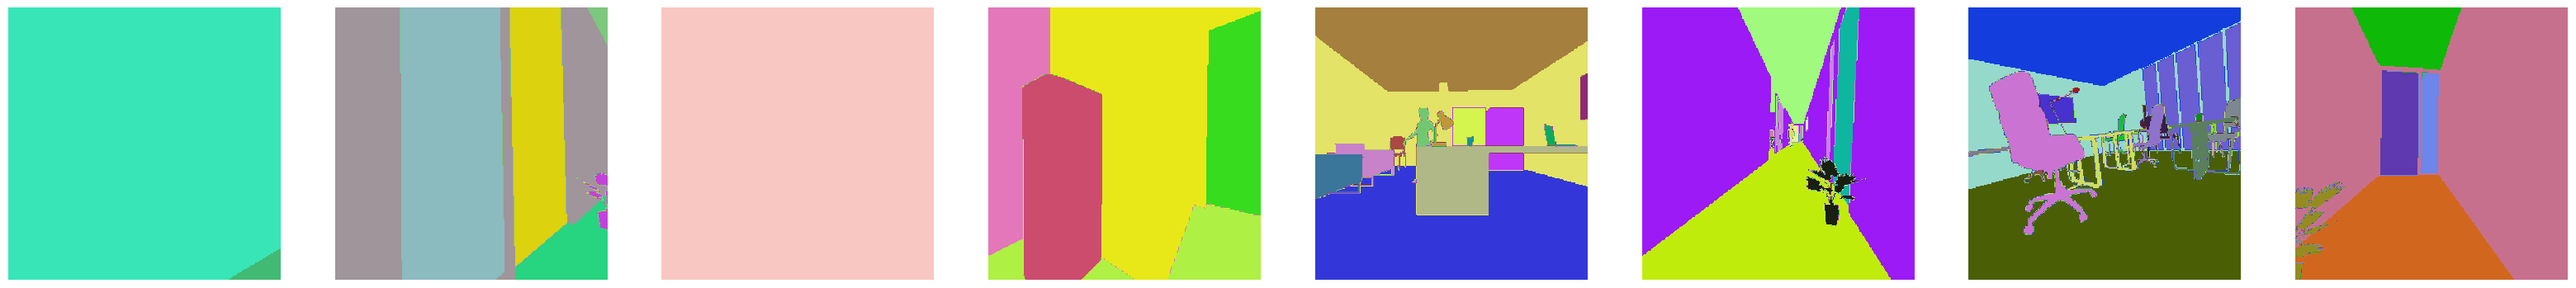

In [2]:
from torch.utils.data import Dataset
import torch
from scipy.spatial import distance

class CustomStreamingSegmentationDataset(Dataset):
    def __init__(self, image_paths, segmentation_paths, image_size, index_map=None):
        self.image_paths = image_paths
        self.segmentation_paths = segmentation_paths
        self.image_size = image_size
        
        image_counts = [DatasetFunctions.getFileDataLen(file_name, image_size, 3, np.uint8) for file_name in image_paths]
        segmentation_counts = [DatasetFunctions.getFileDataLen(file_name, image_size, 1, np.float32) for file_name in segmentation_paths]
        self.len = [min(a, b) for a, b in zip(image_counts, segmentation_counts)]

        self.index_map=index_map

    def __len__(self):
        if self.index_map == None:
            return sum(self.len)
        else:
            return len(self.index_map)

    def __getitem__(self, index):
        if self.index_map != None:
            index = self.index_map[index]

        # Initialize the starting index of the first file
        start = 0
        # Iterate through each length in the list
        for i, length in enumerate(self.len):
            # Calculate the end index for the current file
            end = start + length
            
            # Check if the index falls within the current file range
            if start <= index < end:
                # Calculate the local index within the file
                local_index = index - start
                file_index=i
                break
            
            # Update the start index for the next file
            start = end

        image = Image.fromarray(DatasetFunctions.readFileData(self.image_paths[file_index], local_index, self.image_size, 3, np.uint8).reshape(self.image_size, self.image_size, 3))
        segmentation = DatasetFunctions.readFileData(self.segmentation_paths[file_index], local_index, self.image_size, 1, np.float32).reshape(self.image_size, self.image_size, 1)

        sample = {
            'pixel_values': image,  
            'label': segmentation  
        }
        return sample

    def split_this(self, train_ratio): #train ratio between 0 and 1
        indices = list(range(sum(self.len)))
        random.shuffle(indices)

        split_point = int(sum(self.len) * train_ratio)
        train = indices[:split_point] 
        test = indices[split_point:] 

        train_set = CustomStreamingSegmentationDataset(self.image_paths, self.segmentation_paths, self.image_size, index_map=train)
        test_set = CustomStreamingSegmentationDataset(self.image_paths, self.segmentation_paths, self.image_size, index_map=test)

        return train_set, test_set
    

image_file = "Camera_Images.bin"
segmentation_file = "Camera_Segmentation.bin"
image_size = 256
image_files = []
segmentation_files = []

directory_path = Path("VisionData")
directories = [d for d in directory_path.iterdir() if d.is_dir()]
print(directories)
for directory in directories:
    image_files.append(str(directory)+"\\"+image_file)
    segmentation_files.append(str(directory)+"\\"+segmentation_file)

dataset = CustomStreamingSegmentationDataset(image_files, segmentation_files, image_size)
train_dataset, eval_dataset = dataset.split_this(.8)
print(f"Total Samples: {len(dataset)}")

samples = [eval_dataset[index] for index in range(8)]
test_images = [sample['pixel_values'] for sample in samples]
test_segments = [sample['label'] for sample in samples]

DatasetFunctions.display_images_horizontally(test_images)
DatasetFunctions.display_segmentations_horizontally(test_segments)

##### Mask2Former

- https://huggingface.co/facebook/mask2former-swin-small-coco-panoptic

loading configuration file preprocessor_config.json from cache at C:\Users\Dylan\.cache\huggingface\hub\models--facebook--mask2former-swin-small-coco-panoptic\snapshots\823b60a9dddf1829580505654f6a00b306a65381\preprocessor_config.json
z:\Thesis\Robot\.venv\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)
Image processor Mask2FormerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "ignore_index": 255,
  "image_mean": [
    0.48500001430511475,
    0.4560000002384186,
    0.4059999883174896
  ],
  "image_processor_type": "Mask2FormerImageProcessor",
  "image_std": [
    0.2290000021457672,
    0.2239999920129776,
    0.22499999403953552
  ],
  "num_labels": 133,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width

<PIL.Image.Image image mode=RGB size=256x256 at 0x2A7BACB3D10>
torch.Size([8, 3, 384, 384])


`label_ids_to_fuse` unset. No instance will be fused.


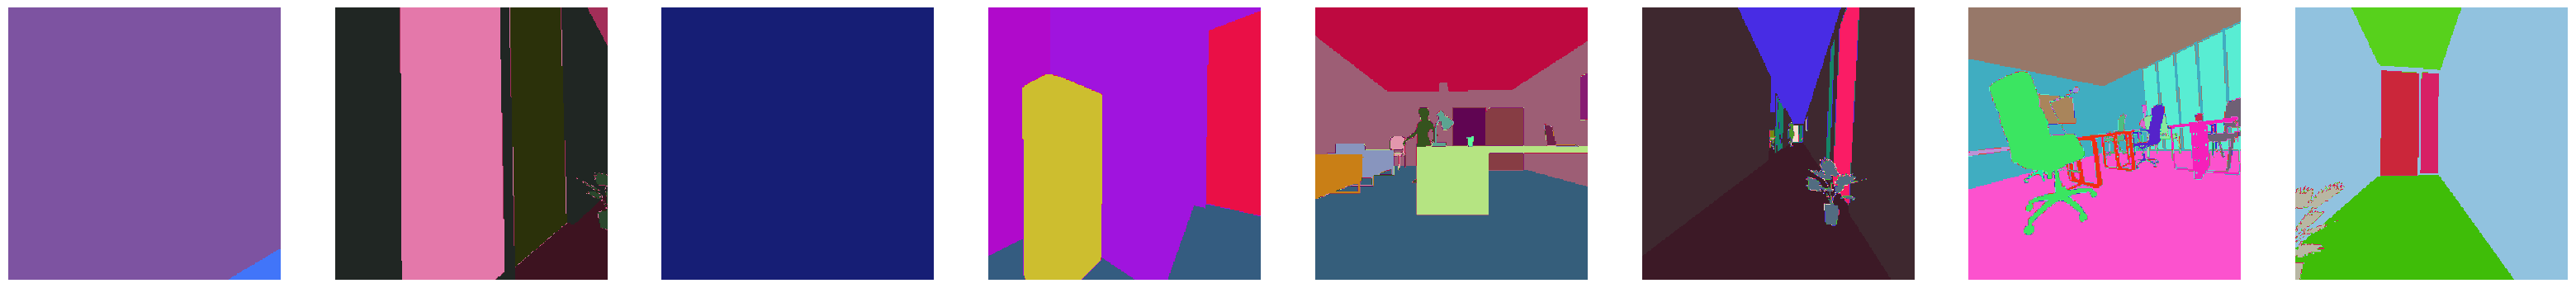

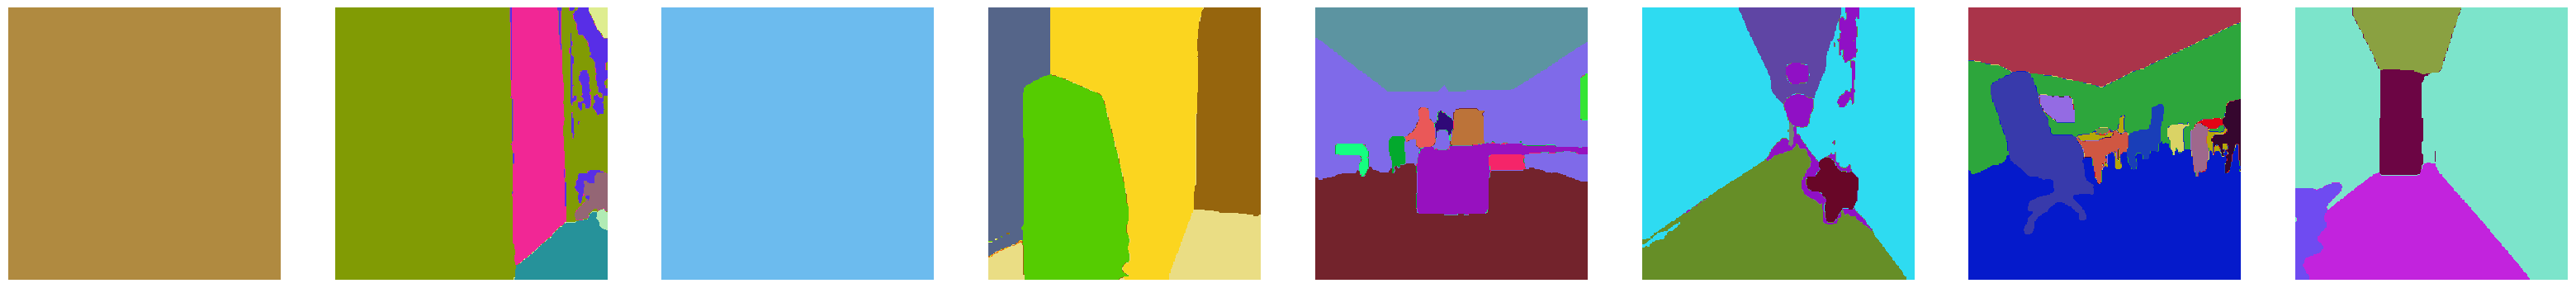

In [10]:
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-coco-panoptic")

print(test_images[0])

inputs = processor(images=test_images, return_tensors="pt")
print(inputs['pixel_values'].shape)
with torch.no_grad():
    m2f_outputs = model(**inputs)
    sizes = [test_images[0].size[::-1]]
    num_repeats = len(test_images)
    new_sizes = [size for size in sizes for _ in range(num_repeats)]
    m2f_result = processor.post_process_panoptic_segmentation(m2f_outputs, target_sizes=new_sizes)

out_maps = []
for result in m2f_result:
    out_maps.append(result['segmentation'])

DatasetFunctions.display_segmentations_horizontally(test_segments)
DatasetFunctions.display_segmentations_horizontally(out_maps)

##### Custom Data Collator

In [4]:
class CustomSegmentationCollator:
    def __init__(self, processor, id2label, label2id):
        self.processor = processor 
        self.id2id = {id_: label2id[label] for id_, label in id2label.items()}
        
    def __call__(self, batch):
        #print(batch[0].keys())
        # Extract images and labels from the batch
        images = [item['pixel_values'] for item in batch]
        segments = [item['label'] for item in batch]
        segmentation_maps = [sample.squeeze().astype(np.uint8) for sample in segments]

        # Flattened indices where the label is 0
        # flattened_indices = [
        #     np.ravel_multi_index(np.where(item['label'] == 0), item['label'].shape)
        #     for item in batch
        # ]
        # # Concatenate all indices into a single array
        # all_indices = np.concatenate(flattened_indices)
        # # Get unique indices
        # unique_indices = np.unique(all_indices)
        # if unique_indices.shape[0]<1:
        #     unique_indices=None
        # else:
        #     print(unique_indices)
           #print(bad_values)
        # Convert images to tensors
        inputs = self.processor(images, segmentation_maps=segmentation_maps, instance_id_to_semantic_id=self.id2id, return_tensors="pt")

        # Return a dictionary that includes your batched data
        return {'pixel_values': inputs['pixel_values'], 'pixel_mask': inputs['pixel_mask'], 'mask_labels': inputs['mask_labels'], 'class_labels': inputs['class_labels']}

##### Custom Trainer Class

In [5]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # print("hi: ")
        # print(inputs.keys())
        # #print(inputs)
        # input = inputs.get('inputs')
        # Forward pass
        outputs = model(**inputs)
        loss = outputs.loss
        #print(f'Loss: {loss}')

        return (loss, outputs) if return_outputs else loss

##### Custom Training

In [11]:
from transformers import TrainingArguments

processor.save_pretrained("Models\\Segmentation")
training_args = TrainingArguments(
    output_dir='./Models/Segmentation/results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    logging_dir='./Models/Segmentation/logs',
    logging_steps=10,  # Log every 10 steps
    log_level='info',  # Set logging level to 'info'
    report_to="tensorboard",  # Send logs to tensorboard (optional)
    evaluation_strategy="steps",  # Enable evaluation during training
    eval_steps=10,  # Run evaluation (and log eval loss) every 10 steps
)

id2label = DatasetFunctions.load_map_from_json_file("VisionData\\id2label.json")
label2id = model.config.label2id
collator = CustomSegmentationCollator(processor, id2label=id2label, label2id=label2id)

# Initialize the custom trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collator,
)

device = next(trainer.model.parameters()).device
print(f'Model is on device: {device}')

# Train the model
trainer.train()

Image processor saved in Models\Segmentation\preprocessor_config.json
z:\Thesis\Robot\.venv\Lib\site-packages\transformers\training_args.py:1539: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices


Model is on device: cuda:0


***** Running training *****
  Num examples = 1,291
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 324
  Number of trainable parameters = 68,753,168
`backbone_config` is `None`. Initializing the config with the default `Swin` backbone.


  0%|          | 0/324 [00:00<?, ?it/s]


***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 44.9342, 'grad_norm': 360.4695739746094, 'learning_rate': 4.845679012345679e-05, 'epoch': 0.06}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 31.33538055419922, 'eval_runtime': 11.1622, 'eval_samples_per_second': 28.937, 'eval_steps_per_second': 3.673, 'epoch': 0.06}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 31.9371, 'grad_norm': 291.6924133300781, 'learning_rate': 4.691358024691358e-05, 'epoch': 0.12}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 27.432106018066406, 'eval_runtime': 11.4604, 'eval_samples_per_second': 28.184, 'eval_steps_per_second': 3.578, 'epoch': 0.12}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 24.7076, 'grad_norm': 194.97181701660156, 'learning_rate': 4.5370370370370374e-05, 'epoch': 0.19}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 25.16533660888672, 'eval_runtime': 11.2291, 'eval_samples_per_second': 28.765, 'eval_steps_per_second': 3.651, 'epoch': 0.19}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 23.8777, 'grad_norm': 289.1581115722656, 'learning_rate': 4.3827160493827164e-05, 'epoch': 0.25}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 24.264848709106445, 'eval_runtime': 11.4868, 'eval_samples_per_second': 28.119, 'eval_steps_per_second': 3.569, 'epoch': 0.25}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 22.6944, 'grad_norm': 188.17050170898438, 'learning_rate': 4.2283950617283955e-05, 'epoch': 0.31}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 23.006155014038086, 'eval_runtime': 11.3844, 'eval_samples_per_second': 28.372, 'eval_steps_per_second': 3.601, 'epoch': 0.31}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 26.2353, 'grad_norm': 254.35882568359375, 'learning_rate': 4.074074074074074e-05, 'epoch': 0.37}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 22.203718185424805, 'eval_runtime': 11.4927, 'eval_samples_per_second': 28.105, 'eval_steps_per_second': 3.567, 'epoch': 0.37}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 24.8818, 'grad_norm': 161.69174194335938, 'learning_rate': 3.9197530864197535e-05, 'epoch': 0.43}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 21.29749870300293, 'eval_runtime': 11.5098, 'eval_samples_per_second': 28.063, 'eval_steps_per_second': 3.562, 'epoch': 0.43}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 20.4731, 'grad_norm': 154.41928100585938, 'learning_rate': 3.7654320987654326e-05, 'epoch': 0.49}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 20.837217330932617, 'eval_runtime': 11.476, 'eval_samples_per_second': 28.146, 'eval_steps_per_second': 3.573, 'epoch': 0.49}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 21.2125, 'grad_norm': 296.7294006347656, 'learning_rate': 3.611111111111111e-05, 'epoch': 0.56}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 20.496898651123047, 'eval_runtime': 11.5161, 'eval_samples_per_second': 28.048, 'eval_steps_per_second': 3.56, 'epoch': 0.56}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 21.8107, 'grad_norm': 354.0595703125, 'learning_rate': 3.45679012345679e-05, 'epoch': 0.62}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 19.91192054748535, 'eval_runtime': 11.5405, 'eval_samples_per_second': 27.988, 'eval_steps_per_second': 3.553, 'epoch': 0.62}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 21.1373, 'grad_norm': 257.1415100097656, 'learning_rate': 3.30246913580247e-05, 'epoch': 0.68}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 19.93549919128418, 'eval_runtime': 11.5594, 'eval_samples_per_second': 27.943, 'eval_steps_per_second': 3.547, 'epoch': 0.68}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 19.5331, 'grad_norm': 162.69622802734375, 'learning_rate': 3.148148148148148e-05, 'epoch': 0.74}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 19.59782600402832, 'eval_runtime': 11.3775, 'eval_samples_per_second': 28.389, 'eval_steps_per_second': 3.604, 'epoch': 0.74}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 20.193, 'grad_norm': 105.42137908935547, 'learning_rate': 2.993827160493827e-05, 'epoch': 0.8}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 19.461454391479492, 'eval_runtime': 11.2658, 'eval_samples_per_second': 28.671, 'eval_steps_per_second': 3.639, 'epoch': 0.8}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 20.8991, 'grad_norm': 146.41172790527344, 'learning_rate': 2.839506172839506e-05, 'epoch': 0.86}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 19.417316436767578, 'eval_runtime': 11.3305, 'eval_samples_per_second': 28.507, 'eval_steps_per_second': 3.619, 'epoch': 0.86}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 17.0326, 'grad_norm': 271.8606872558594, 'learning_rate': 2.6851851851851855e-05, 'epoch': 0.93}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 19.1463565826416, 'eval_runtime': 11.5343, 'eval_samples_per_second': 28.004, 'eval_steps_per_second': 3.555, 'epoch': 0.93}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 23.9391, 'grad_norm': 171.06729125976562, 'learning_rate': 2.5308641975308646e-05, 'epoch': 0.99}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 18.586130142211914, 'eval_runtime': 11.1345, 'eval_samples_per_second': 29.009, 'eval_steps_per_second': 3.682, 'epoch': 0.99}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 15.7036, 'grad_norm': 183.9747772216797, 'learning_rate': 2.3765432098765433e-05, 'epoch': 1.05}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 18.522159576416016, 'eval_runtime': 11.1733, 'eval_samples_per_second': 28.908, 'eval_steps_per_second': 3.669, 'epoch': 1.05}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 19.2505, 'grad_norm': 180.68539428710938, 'learning_rate': 2.2222222222222223e-05, 'epoch': 1.11}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 18.285890579223633, 'eval_runtime': 11.1386, 'eval_samples_per_second': 28.998, 'eval_steps_per_second': 3.681, 'epoch': 1.11}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 17.7781, 'grad_norm': 421.5394287109375, 'learning_rate': 2.0679012345679014e-05, 'epoch': 1.17}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 18.21371841430664, 'eval_runtime': 11.1744, 'eval_samples_per_second': 28.905, 'eval_steps_per_second': 3.669, 'epoch': 1.17}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 18.6383, 'grad_norm': 99.72552490234375, 'learning_rate': 1.91358024691358e-05, 'epoch': 1.23}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 18.038236618041992, 'eval_runtime': 11.1199, 'eval_samples_per_second': 29.047, 'eval_steps_per_second': 3.687, 'epoch': 1.23}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 17.9479, 'grad_norm': 81.23611450195312, 'learning_rate': 1.7592592592592595e-05, 'epoch': 1.3}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.962276458740234, 'eval_runtime': 11.1529, 'eval_samples_per_second': 28.961, 'eval_steps_per_second': 3.676, 'epoch': 1.3}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 18.9954, 'grad_norm': 198.46160888671875, 'learning_rate': 1.604938271604938e-05, 'epoch': 1.36}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.836851119995117, 'eval_runtime': 11.1549, 'eval_samples_per_second': 28.956, 'eval_steps_per_second': 3.676, 'epoch': 1.36}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 17.6339, 'grad_norm': 147.3219451904297, 'learning_rate': 1.4506172839506174e-05, 'epoch': 1.42}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.61351776123047, 'eval_runtime': 11.0984, 'eval_samples_per_second': 29.103, 'eval_steps_per_second': 3.694, 'epoch': 1.42}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 18.0669, 'grad_norm': 89.60118103027344, 'learning_rate': 1.2962962962962962e-05, 'epoch': 1.48}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.438495635986328, 'eval_runtime': 11.0006, 'eval_samples_per_second': 29.362, 'eval_steps_per_second': 3.727, 'epoch': 1.48}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 16.3719, 'grad_norm': 97.63866424560547, 'learning_rate': 1.1419753086419753e-05, 'epoch': 1.54}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.49323272705078, 'eval_runtime': 11.0486, 'eval_samples_per_second': 29.234, 'eval_steps_per_second': 3.711, 'epoch': 1.54}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 18.4053, 'grad_norm': 263.1290283203125, 'learning_rate': 9.876543209876543e-06, 'epoch': 1.6}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.316862106323242, 'eval_runtime': 11.3686, 'eval_samples_per_second': 28.412, 'eval_steps_per_second': 3.606, 'epoch': 1.6}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 18.3256, 'grad_norm': 94.1318359375, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.67}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.215736389160156, 'eval_runtime': 11.4348, 'eval_samples_per_second': 28.247, 'eval_steps_per_second': 3.586, 'epoch': 1.67}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 18.604, 'grad_norm': 105.45431518554688, 'learning_rate': 6.790123456790123e-06, 'epoch': 1.73}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.16665267944336, 'eval_runtime': 11.3541, 'eval_samples_per_second': 28.448, 'eval_steps_per_second': 3.611, 'epoch': 1.73}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 18.3749, 'grad_norm': 164.98548889160156, 'learning_rate': 5.246913580246914e-06, 'epoch': 1.79}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.162031173706055, 'eval_runtime': 11.3106, 'eval_samples_per_second': 28.557, 'eval_steps_per_second': 3.625, 'epoch': 1.79}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 16.1076, 'grad_norm': 223.98194885253906, 'learning_rate': 3.7037037037037037e-06, 'epoch': 1.85}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.080163955688477, 'eval_runtime': 11.0682, 'eval_samples_per_second': 29.183, 'eval_steps_per_second': 3.704, 'epoch': 1.85}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 13.2028, 'grad_norm': 128.12411499023438, 'learning_rate': 2.1604938271604937e-06, 'epoch': 1.91}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.060041427612305, 'eval_runtime': 10.9081, 'eval_samples_per_second': 29.611, 'eval_steps_per_second': 3.759, 'epoch': 1.91}



***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'loss': 17.7911, 'grad_norm': 100.93253326416016, 'learning_rate': 6.17283950617284e-07, 'epoch': 1.98}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 17.0592041015625, 'eval_runtime': 10.9053, 'eval_samples_per_second': 29.619, 'eval_steps_per_second': 3.76, 'epoch': 1.98}


Saving model checkpoint to ./Models/Segmentation/results\checkpoint-324
`backbone_config` is `None`. Initializing the config with the default `Swin` backbone.
`backbone_config` is `None`. Initializing the config with the default `Swin` backbone.
`backbone_config` is `None`. Initializing the config with the default `Swin` backbone.
Configuration saved in ./Models/Segmentation/results\checkpoint-324\config.json
Model weights saved in ./Models/Segmentation/results\checkpoint-324\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 540.6095, 'train_samples_per_second': 4.776, 'train_steps_per_second': 0.599, 'train_loss': 20.770699112503618, 'epoch': 2.0}


TrainOutput(global_step=324, training_loss=20.770699112503618, metrics={'train_runtime': 540.6095, 'train_samples_per_second': 4.776, 'train_steps_per_second': 0.599, 'total_flos': 4.708206631452672e+17, 'train_loss': 20.770699112503618, 'epoch': 2.0})

### Results

torch.Size([8, 3, 384, 384])


`label_ids_to_fuse` unset. No instance will be fused.


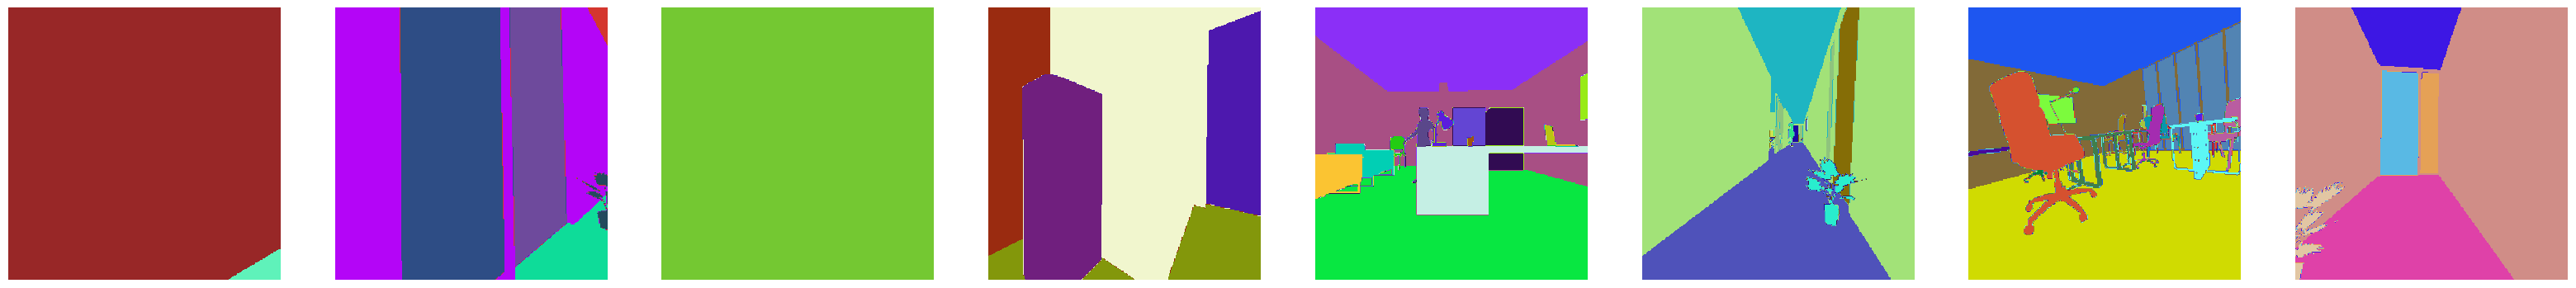

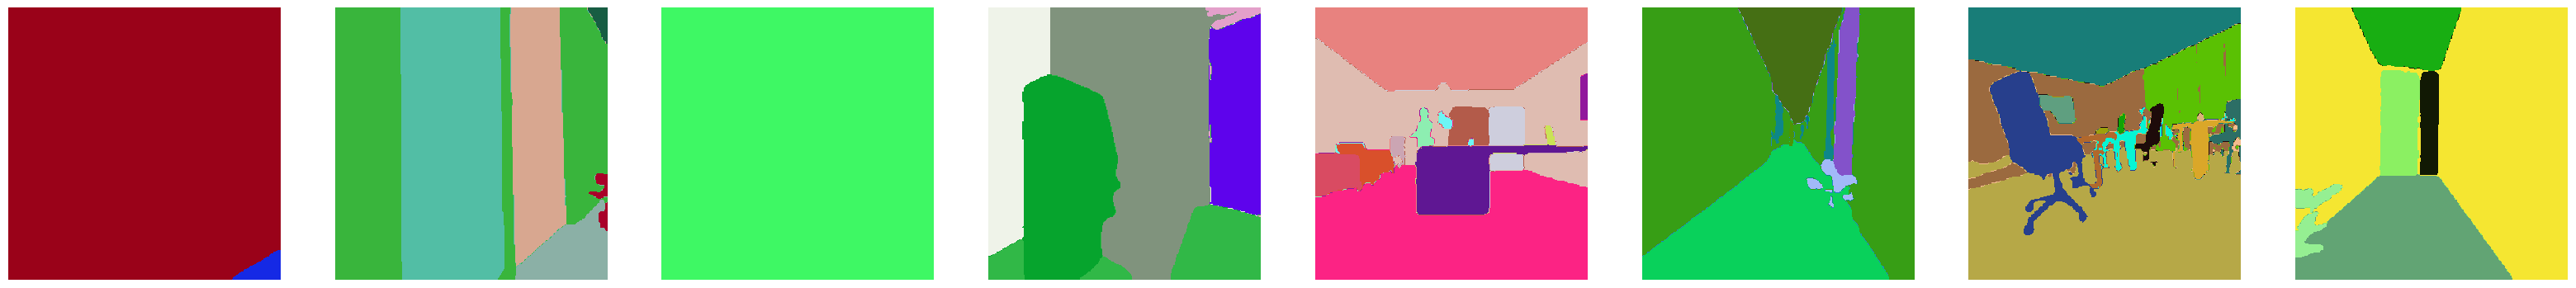

In [12]:
inputs = processor(images=test_images, return_tensors="pt").to('cuda')
print(inputs['pixel_values'].shape)
with torch.no_grad():
    m2f_outputs = model(**inputs)
    sizes = [test_images[0].size[::-1]]
    num_repeats = len(test_images)
    new_sizes = [size for size in sizes for _ in range(num_repeats)]
    m2f_result = processor.post_process_panoptic_segmentation(m2f_outputs, target_sizes=new_sizes)

out_maps = []
for result in m2f_result:
    out_maps.append(result['segmentation'].to('cpu'))

DatasetFunctions.display_segmentations_horizontally(test_segments)
DatasetFunctions.display_segmentations_horizontally(out_maps)

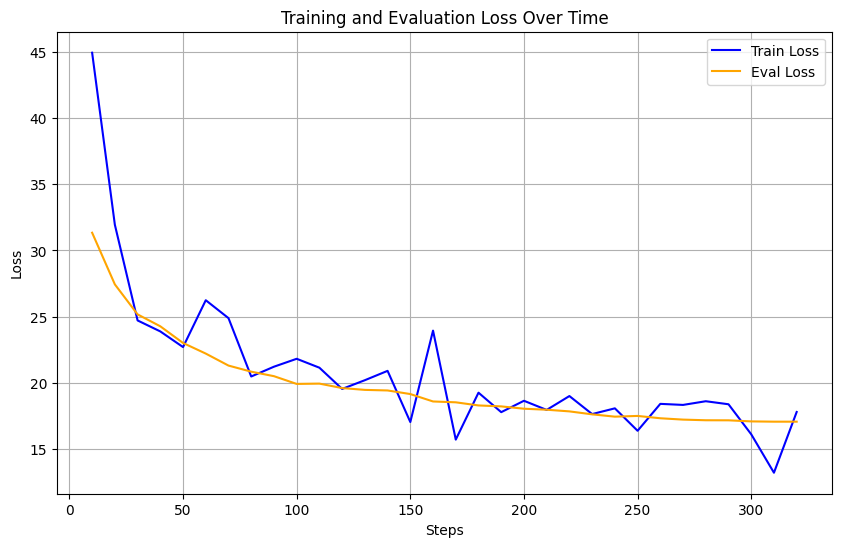

In [13]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Load event logs from the logging directory
log_dir = './Models/Segmentation/logs'

# List all event files
event_files = [os.path.join(log_dir, file) for file in os.listdir(log_dir) if file.startswith('events')]
event_file = max(event_files, key=os.path.getmtime)

# Initialize lists to store training and evaluation losses
train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

# Process each event file
event_acc = EventAccumulator(event_file)
event_acc.Reload()

# Iterate over scalar data
for tag in event_acc.Tags()['scalars']:
    if 'train/loss' in tag:  # Filter for train loss tag
        train_events = event_acc.Scalars(tag)
        for event in train_events:
            train_losses.append(event.value)
            train_steps.append(event.step)

    elif 'eval/loss' in tag:  # Filter for eval loss tag
        eval_events = event_acc.Scalars(tag)
        for event in eval_events:
            eval_losses.append(event.value)
            eval_steps.append(event.step)

# Plot training and evaluation losses
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Train Loss', color='blue')
plt.plot(eval_steps, eval_losses, label='Eval Loss', color='orange')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()
